In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

url = "https://github.com/CynthiaShiyue/IDS701_Causal_Report_Project/raw/data/final_df.csv"
data = pd.read_csv(url)
data["Date"] = pd.to_datetime(data["Date"])
data["event_date"] = pd.to_datetime(data["event_date"])
data = data.dropna(subset=["event_id"])
data = data[data["event_time"] != -1]
data["event_time"] = data["event_time"].astype(float).astype(int)

1. Select the data subset for each event
2. Skip the event if Treatment has no variation
3. Convert event_time to categorical
4. Run the regression: abnormal_return ~ C(event_time) * Treatment + C(ticker), clustered by ticker
5. Extract Treatment-related interaction terms
6. Generate confidence intervals
7. Keep event_time between -10 and 10
8. Plot dynamic Treatment Effects:
   - x-axis: event time
   - y-axis: Treatment Effect estimate
   - Error bars: 95% confidence intervals
   - Add dashed line at t = 0
   - Add labels, legend, and grid

Processing event: 2022_oct_china_chip_export_control


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2726624573.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event['event_time'] = df_event['event_time'].astype('category')


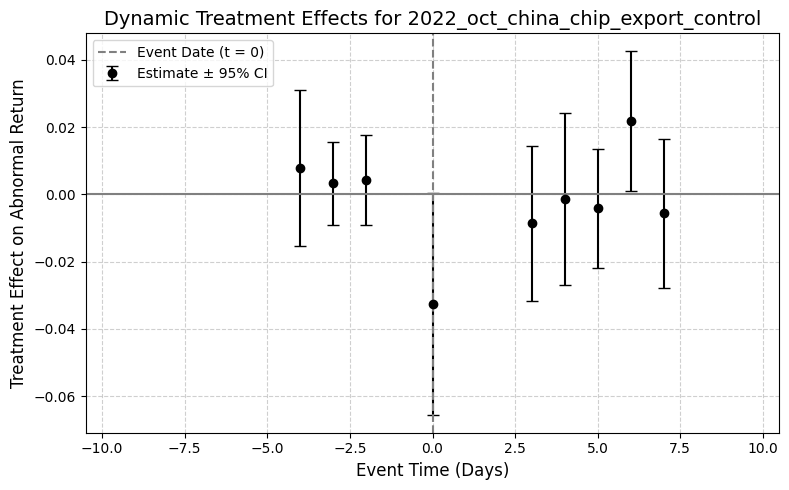

Processing event: 2023_chip_export_controls


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2726624573.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event['event_time'] = df_event['event_time'].astype('category')


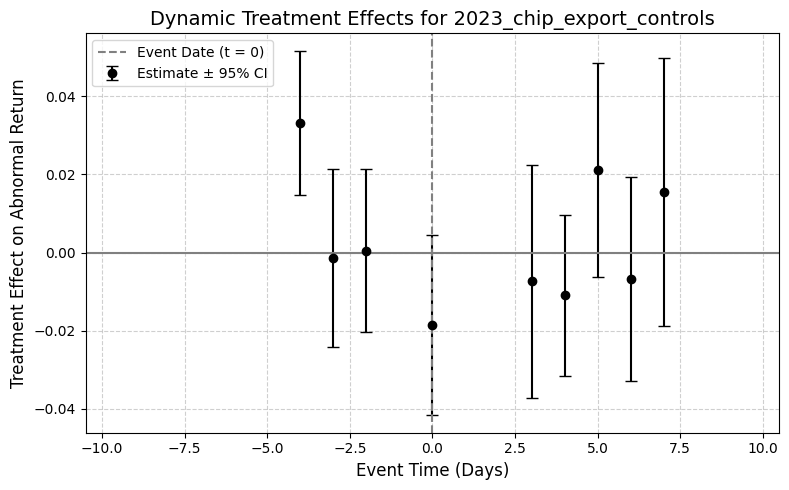

Processing event: 2023_mineral_export_restrictions


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2726624573.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event['event_time'] = df_event['event_time'].astype('category')


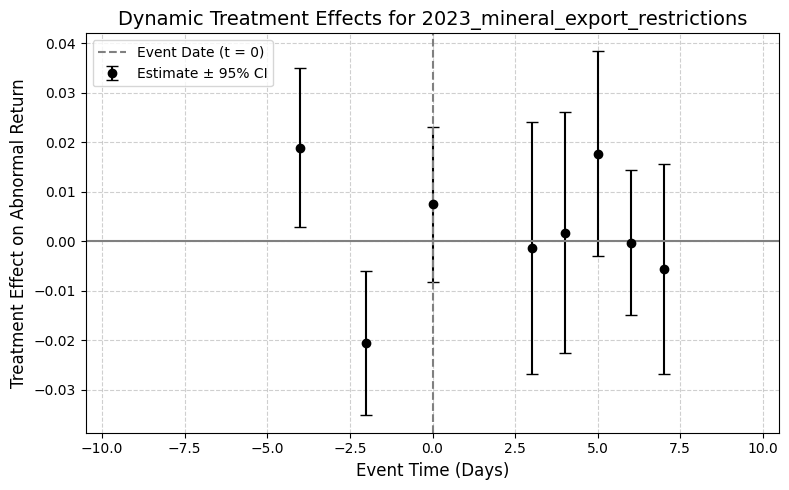

C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2726624573.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event['event_time'] = df_event['event_time'].astype('category')


Processing event: 2023_aug_investment_ban


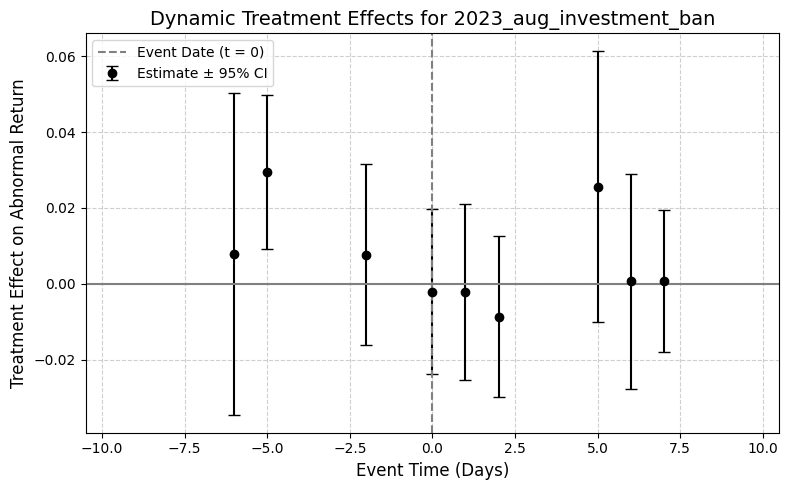

C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2726624573.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event['event_time'] = df_event['event_time'].astype('category')


Processing event: 2023_export_expansion


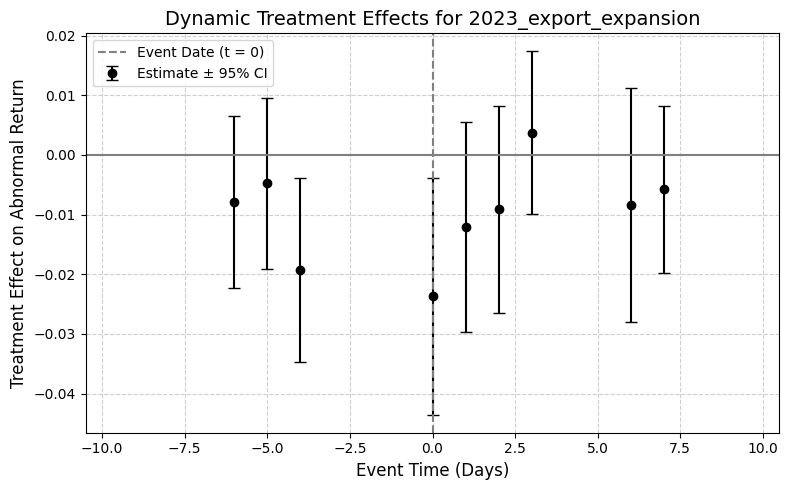

Processing event: 2024_march_export_tightening


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2726624573.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event['event_time'] = df_event['event_time'].astype('category')


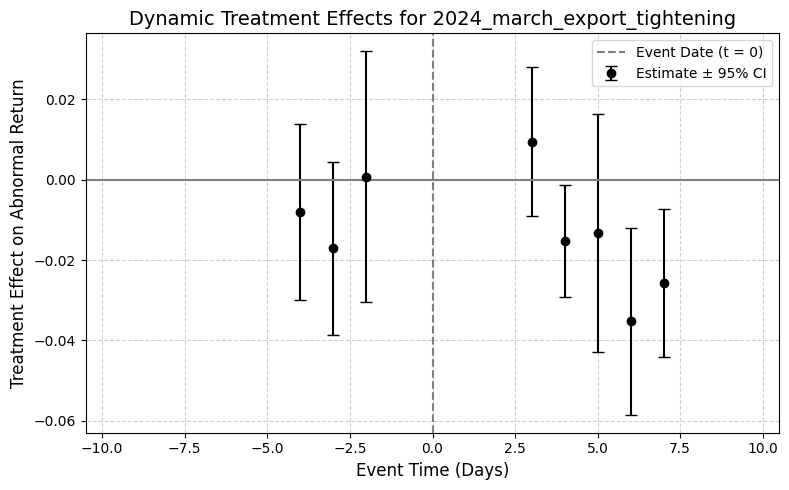

Processing event: 2024_tariff_increase_ev_battery


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2726624573.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event['event_time'] = df_event['event_time'].astype('category')


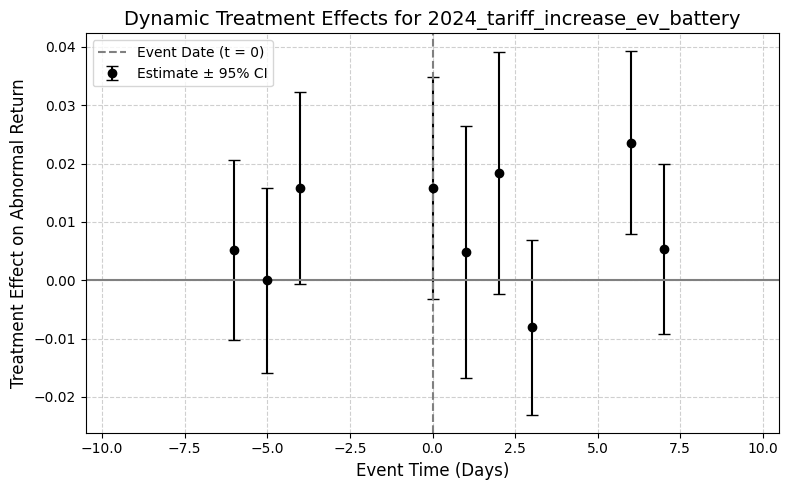

Processing event: 2024_tariff_finalization


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2726624573.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event['event_time'] = df_event['event_time'].astype('category')


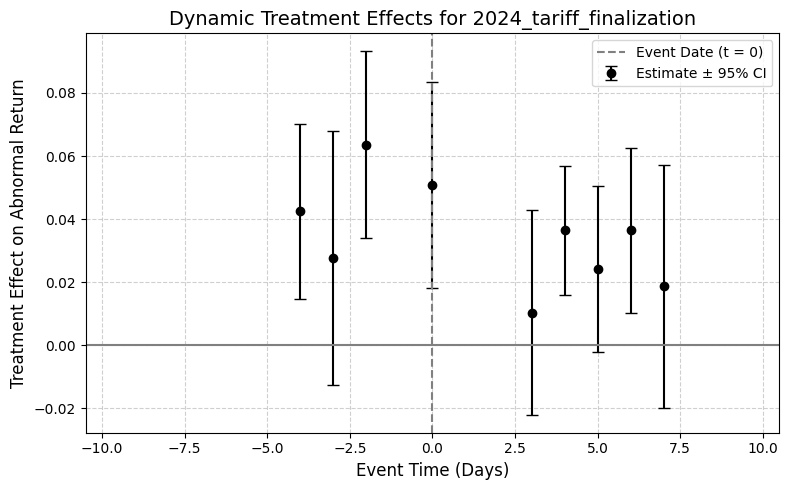

C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2726624573.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event['event_time'] = df_event['event_time'].astype('category')


Processing event: 2024_nvidia_antitrust_probe


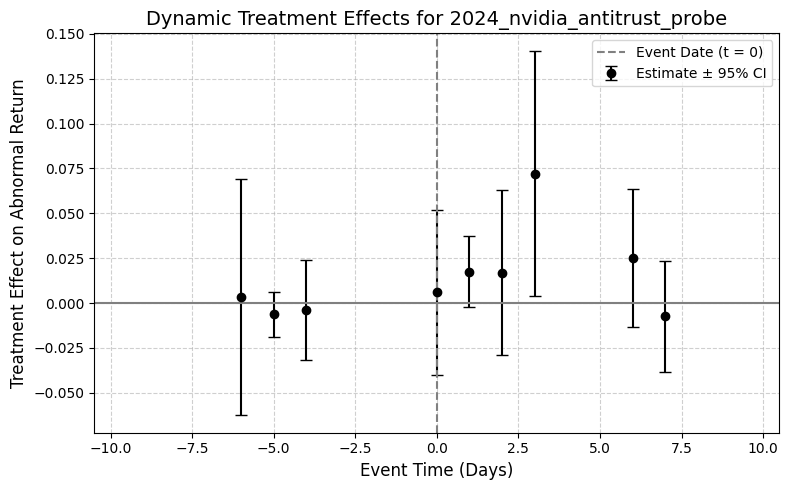

In [4]:
event_list = data['event_id'].unique()

for event in event_list:
    print(f"Processing event: {event}")
    
    df_event = data[data['event_id'] == event]
    
    if df_event['Treatment'].nunique() < 2:
        print(f"Skipping {event} because not enough variation in Treatment")
        continue
    
    df_event['event_time'] = df_event['event_time'].astype('category')
    
    model = smf.ols(
        formula="abnormal_return ~ C(event_time) * Treatment + C(ticker)",
        data=df_event
    ).fit(
        cov_type="cluster",
        cov_kwds={"groups": df_event["ticker"]}
    )
    
    coef = model.params
    conf = model.conf_int()
    
    treat_effect = coef[coef.index.str.contains(r'C\(event_time\)\[T\.-?\d+\]:Treatment')].reset_index()
    treat_effect.columns = ['term', 'coef']
    
    conf_treat = conf.loc[treat_effect['term']]
    treat_effect['lower'] = conf_treat[0].values
    treat_effect['upper'] = conf_treat[1].values
    
    treat_effect['event_time'] = treat_effect['term'].str.extract(r'\[T\.?(-?\d+)\]')[0].astype(int)
    
    treat_effect = treat_effect[treat_effect['event_time'].between(-10, 10)]
    treat_effect = treat_effect.sort_values('event_time')
    
    plt.figure(figsize=(8, 5))
    
    plt.errorbar(
        treat_effect['event_time'],
        treat_effect['coef'],
        yerr=[treat_effect['coef'] - treat_effect['lower'], treat_effect['upper'] - treat_effect['coef']],
        fmt='o', capsize=4, color='black', label='Estimate ± 95% CI'
    )
    plt.axhline(0, color='gray', linestyle='-')
    plt.axvline(0, color='gray', linestyle='--', label='Event Date (t = 0)')
    plt.xlim(-10.5, 10.5)
    plt.title(f'Dynamic Treatment Effects for {event}', fontsize=14)
    plt.xlabel('Event Time (Days)', fontsize=12)
    plt.ylabel('Treatment Effect on Abnormal Return', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

---

- Applied winsorization to abnormal_return at the 1% and 99% levels to reduce the influence of extreme outliers.
- Changed the time window division:
  - Instead of treating each event_time separately, grouped event_time into four bins: Pre_early, Pre_late, Post_early, and Post_late.
- Updated the regression specification:
  - Used C(time_bin) * Treatment instead of C(event_time) * Treatment.
  - Still controlled for ticker fixed effects and used clustered standard errors by ticker.
- Updated the plotting:
  - x-axis changed from event_time (day-by-day) to time_bin (four periods).
  - This makes the treatment effects easier to visualize and interpret across broader periods around the event.

Processing event: 2022_oct_china_chip_export_control


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2921888904.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


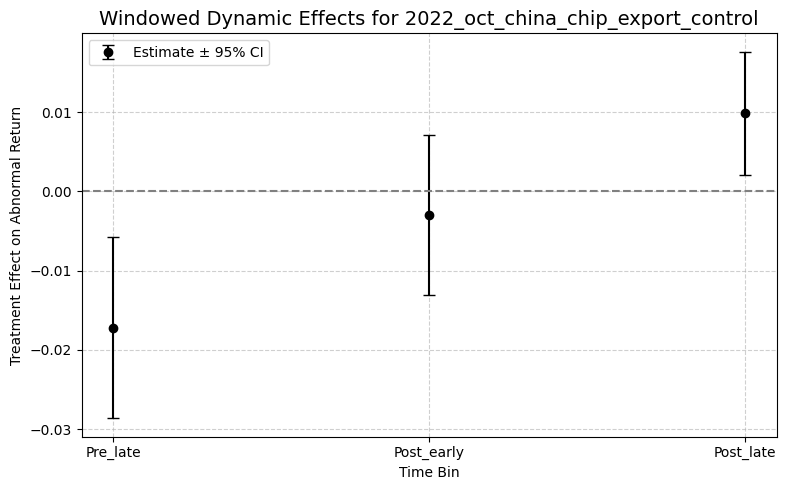

Processing event: 2023_chip_export_controls


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2921888904.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


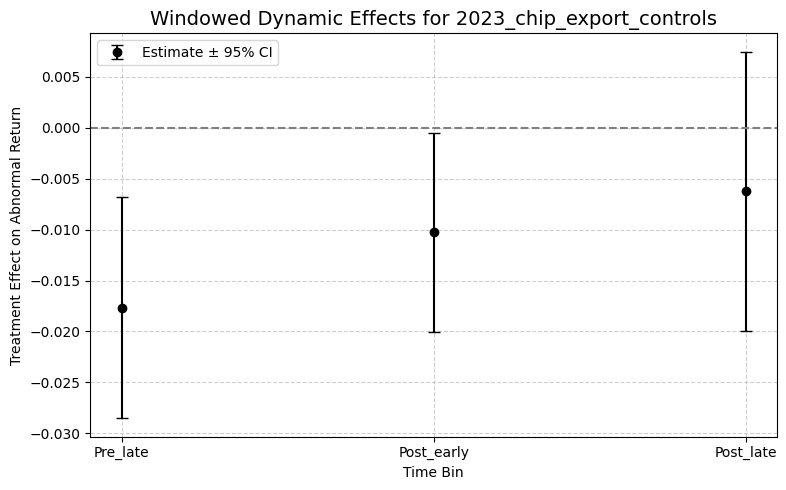

C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2921888904.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


Processing event: 2023_mineral_export_restrictions


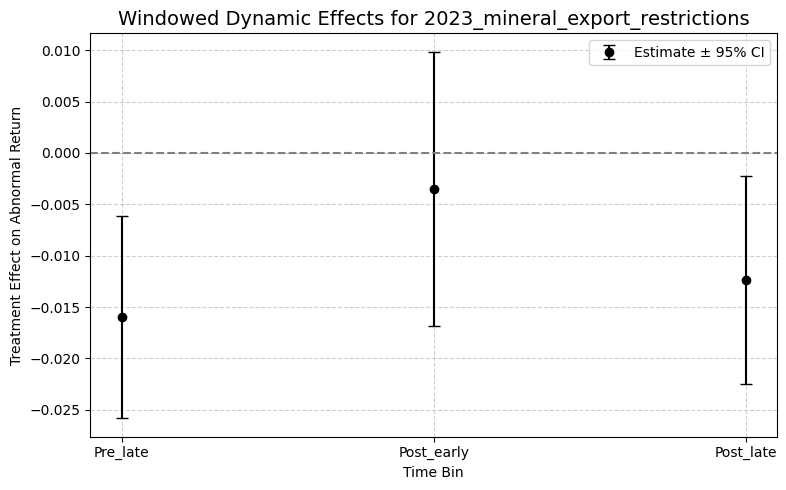

Processing event: 2023_aug_investment_ban


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2921888904.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


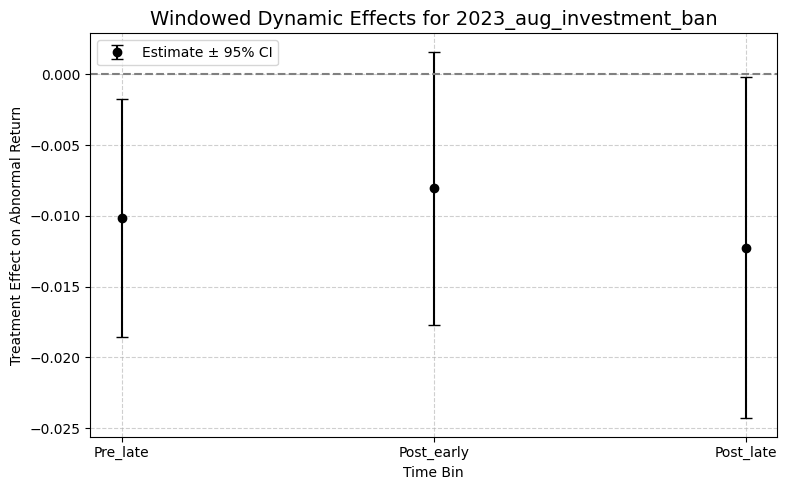

Processing event: 2023_export_expansion


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2921888904.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


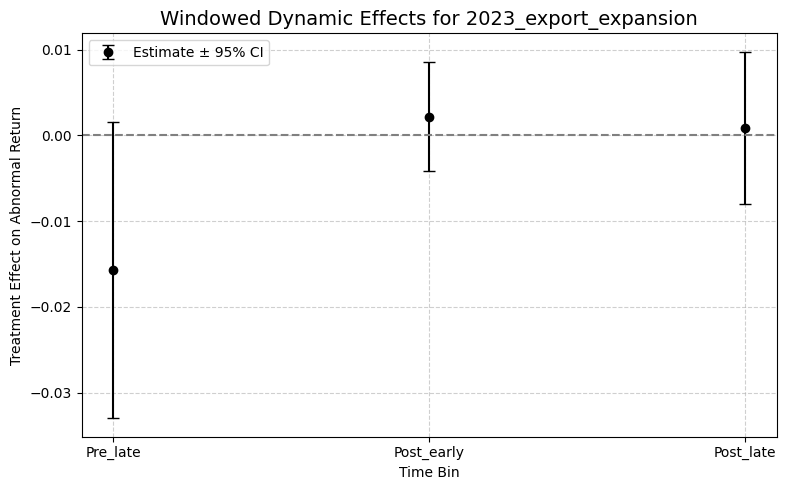

Processing event: 2024_march_export_tightening


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2921888904.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


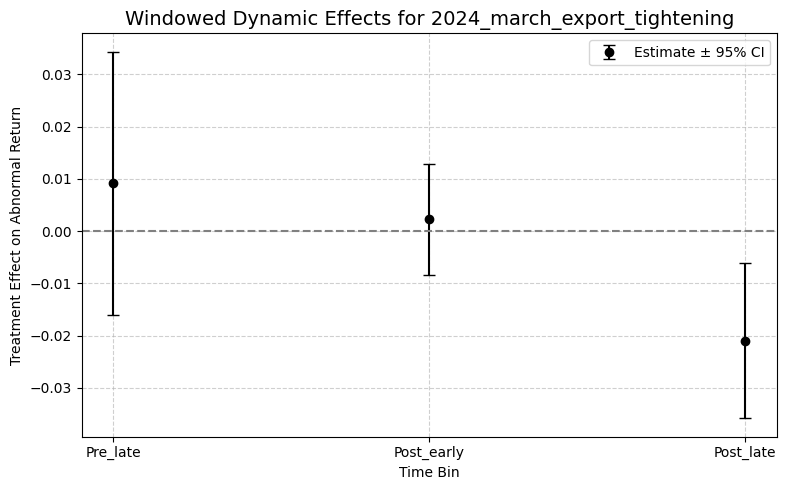

C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2921888904.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


Processing event: 2024_tariff_increase_ev_battery


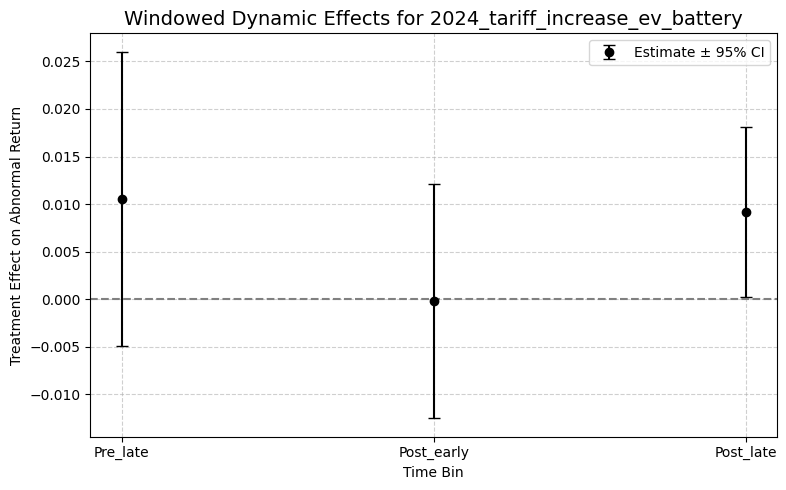

Processing event: 2024_tariff_finalization


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2921888904.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


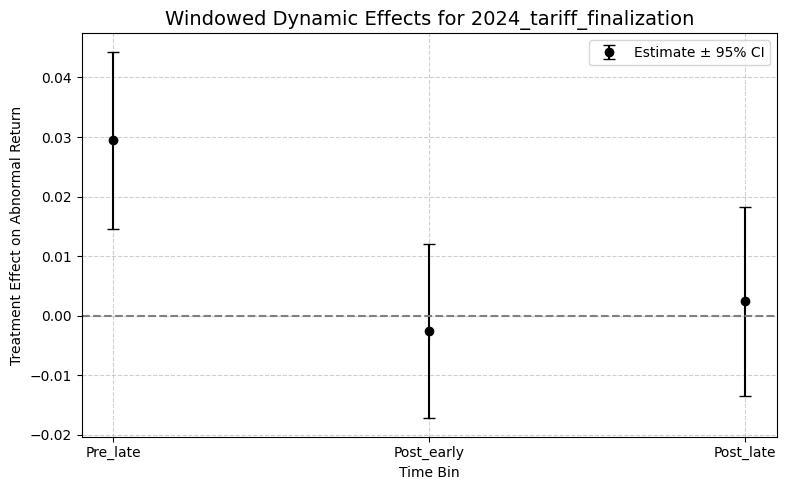

Processing event: 2024_nvidia_antitrust_probe


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2921888904.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


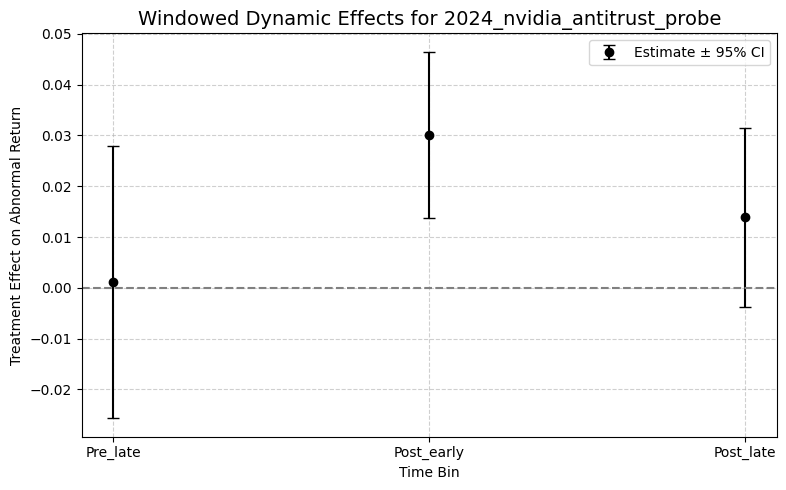

In [24]:
from scipy.stats.mstats import winsorize 

winsorized_returns = winsorize(data["abnormal_return"], limits=[0.01, 0.01])
data["abnormal_return"] = winsorized_returns

event_list = data['event_id'].unique()

for event in event_list:
    print(f"Processing event: {event}")
    
    df_event = data[data['event_id'] == event]
    
    if df_event['Treatment'].nunique() < 2:
        print(f"Skipping {event} because not enough variation in Treatment")
        continue
    
    bins = [-15, -3, 0, 5, 15]
    labels = ["Pre_early", "Pre_late", "Post_early", "Post_late"]
    
    df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)
    
    model = smf.ols(
        formula="abnormal_return ~ C(time_bin) * Treatment + C(ticker)",
        data=df_event
    ).fit(
        cov_type="cluster",
        cov_kwds={"groups": df_event["ticker"]}
    )
    
    coef = model.params
    conf = model.conf_int()
    
    treat_effect = coef[coef.index.str.contains(r'C\(time_bin\)\[T\..*\]:Treatment')].reset_index()
    treat_effect.columns = ['term', 'coef']
    
    conf_treat = conf.loc[treat_effect['term']]
    treat_effect['lower'] = conf_treat[0].values
    treat_effect['upper'] = conf_treat[1].values
    
    treat_effect['bin'] = treat_effect['term'].str.extract(r'\[T\.(.*)\]')[0]
    treat_effect['bin'] = pd.Categorical(treat_effect['bin'], categories=labels, ordered=True)
    treat_effect = treat_effect.sort_values('bin')
    
    plt.figure(figsize=(8, 5))
    
    plt.errorbar(
        treat_effect['bin'],
        treat_effect['coef'],
        yerr=[treat_effect['coef'] - treat_effect['lower'], treat_effect['upper'] - treat_effect['coef']],
        fmt='o', capsize=4, color='black', label='Estimate ± 95% CI'
    )
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f'Windowed Dynamic Effects for {event}', fontsize=14)
    plt.xlabel('Time Bin')
    plt.ylabel('Treatment Effect on Abnormal Return')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

---

- Added lagged_return and absolute_return as additional control variables in the regression model.
- Dropped observations with missing values in lagged_return, absolute_return, or CAR_pre to ensure data completeness.
- Updated the regression specification to:  
  abnormal_return ~ C(time_bin) * Treatment + C(ticker) + lagged_return + absolute_return + CAR_pre
- This further controls for momentum effects and volatility, improving the robustness of the estimated treatment effects.

Processing event: 2022_oct_china_chip_export_control


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2149201151.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


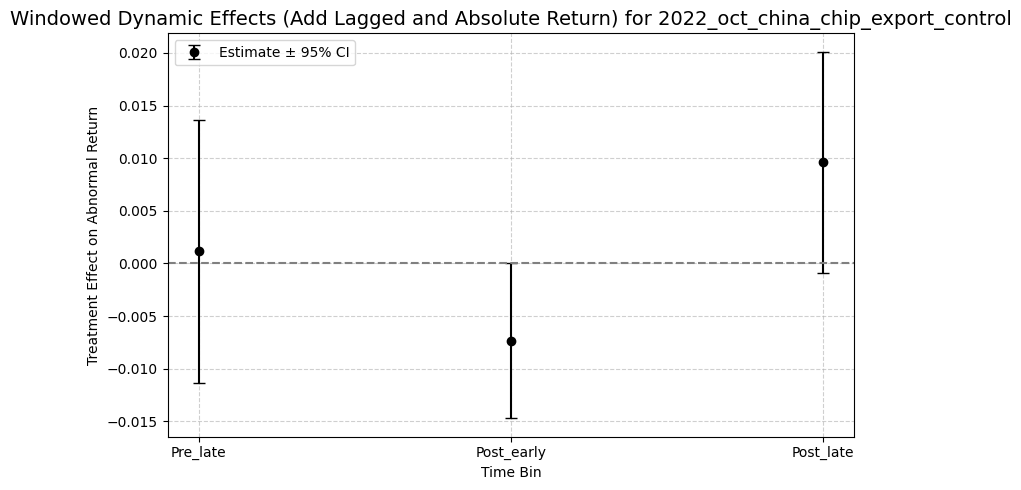

Processing event: 2023_chip_export_controls


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2149201151.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


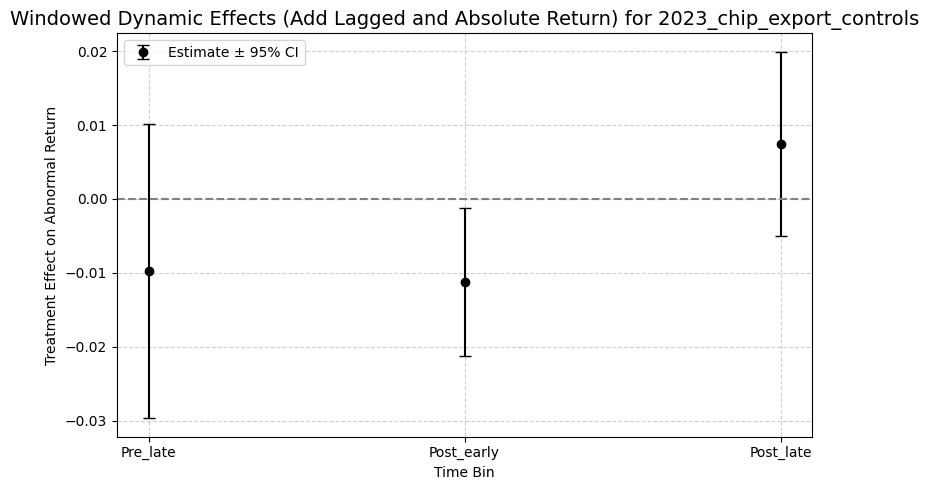

C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2149201151.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


Processing event: 2023_mineral_export_restrictions


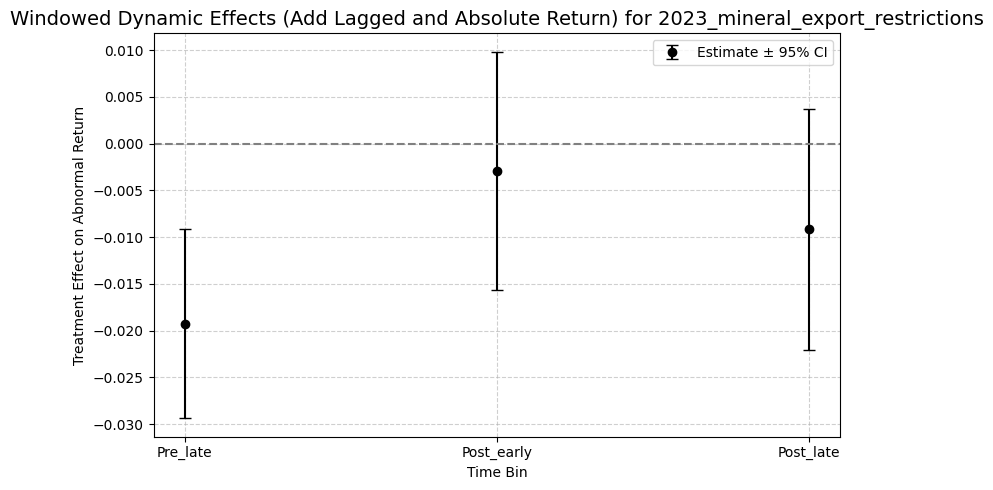

C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2149201151.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


Processing event: 2023_aug_investment_ban


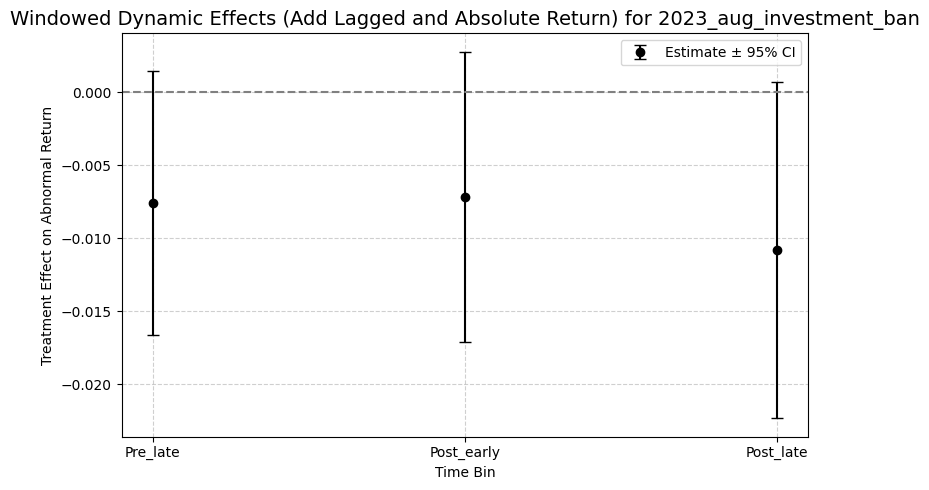

Processing event: 2023_export_expansion


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2149201151.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


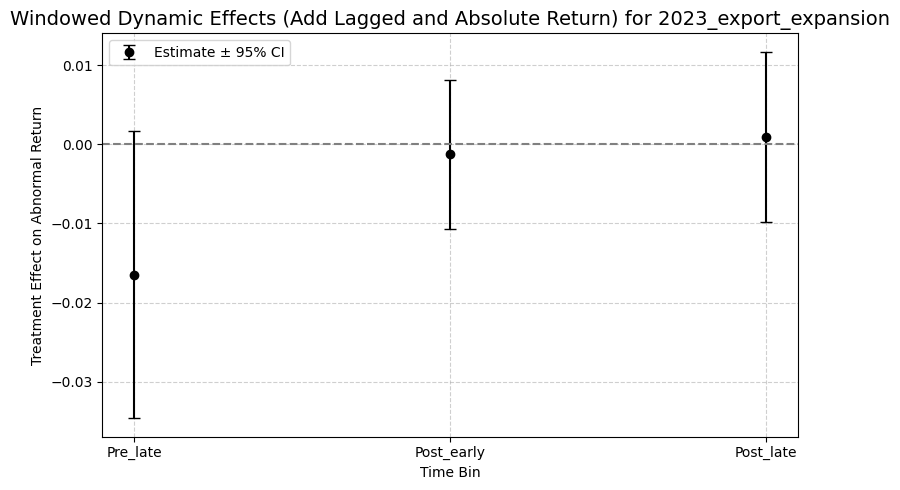

C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2149201151.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


Processing event: 2024_march_export_tightening


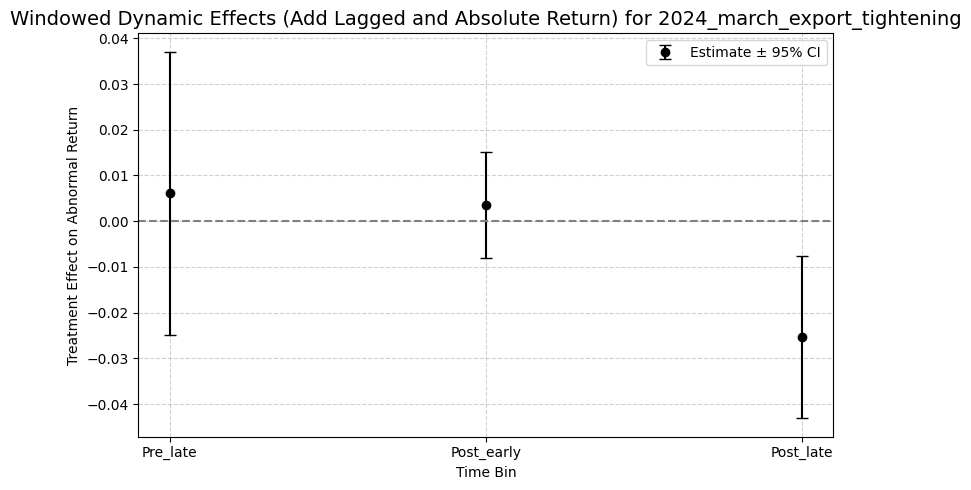

Processing event: 2024_tariff_increase_ev_battery


C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2149201151.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


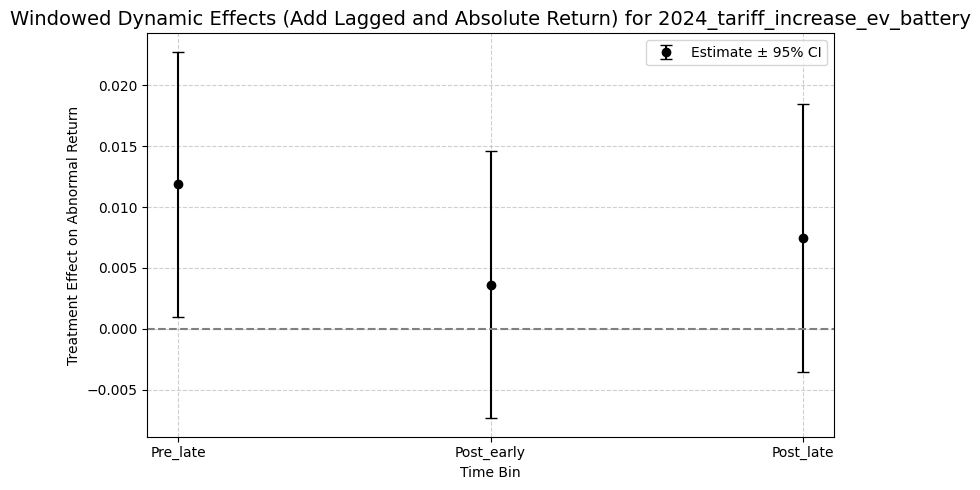

C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2149201151.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


Processing event: 2024_tariff_finalization


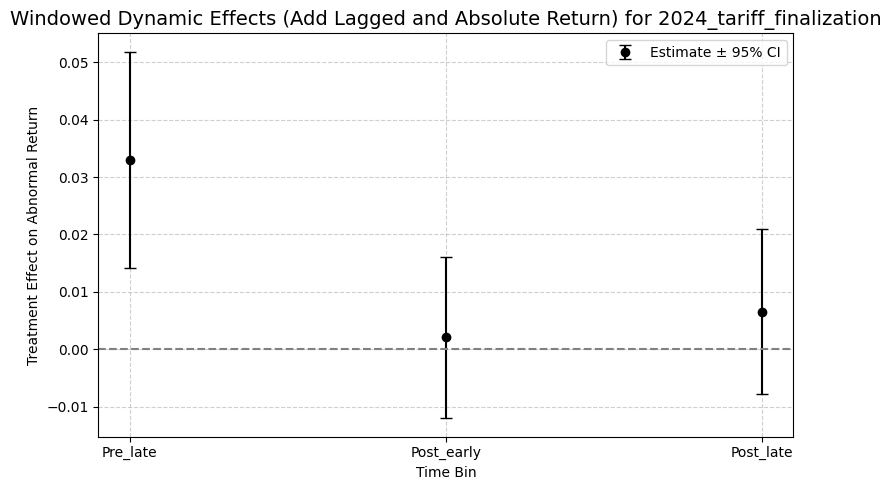

C:\Users\Leo\AppData\Local\Temp\ipykernel_28912\2149201151.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)


Processing event: 2024_nvidia_antitrust_probe


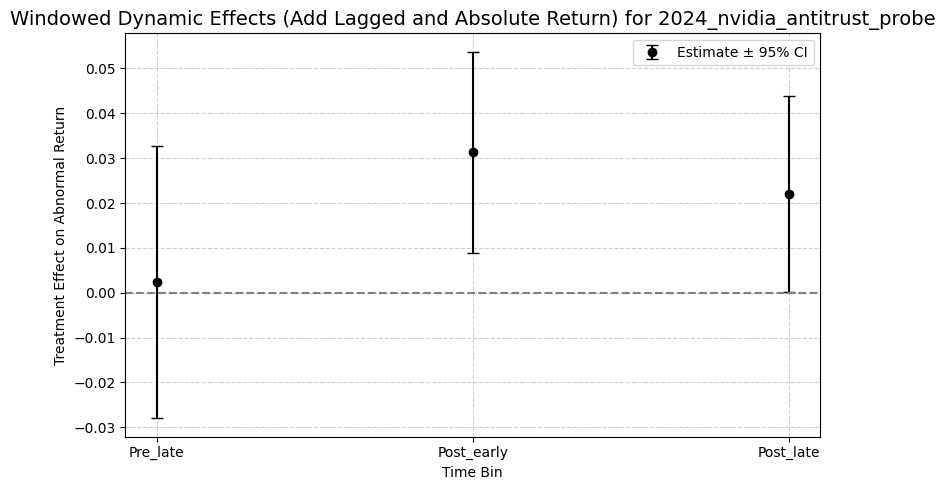

In [19]:
data["lagged_return"] = data.groupby("ticker")["Return"].shift(1)
data["absolute_return"] = data["Return"].abs()

winsorized_returns = winsorize(data["abnormal_return"], limits=[0.01, 0.01])
data["abnormal_return"] = winsorized_returns

data = data.dropna(subset=["lagged_return", "absolute_return", "CAR_pre"])

event_list = data['event_id'].unique()

for event in event_list:
    print(f"Processing event: {event}")
    
    df_event = data[data['event_id'] == event]
    
    if df_event['Treatment'].nunique() < 2:
        print(f"Skipping {event} because not enough variation in Treatment")
        continue
    
    bins = [-15, -3, 0, 5, 15]
    labels = ["Pre_early", "Pre_late", "Post_early", "Post_late"]
    
    df_event["time_bin"] = pd.cut(df_event["event_time"], bins=bins, labels=labels)
    
    model = smf.ols(
        formula="abnormal_return ~ C(time_bin) * Treatment + C(ticker) + lagged_return + absolute_return + CAR_pre",
        data=df_event
    ).fit(
        cov_type="cluster",
        cov_kwds={"groups": df_event["ticker"]}
    )
    
    coef = model.params
    conf = model.conf_int()
    
    treat_effect = coef[coef.index.str.contains(r'C\(time_bin\)\[T\..*\]:Treatment')].reset_index()
    treat_effect.columns = ['term', 'coef']
    
    conf_treat = conf.loc[treat_effect['term']]
    treat_effect['lower'] = conf_treat[0].values
    treat_effect['upper'] = conf_treat[1].values
    
    treat_effect['bin'] = treat_effect['term'].str.extract(r'\[T\.(.*)\]')[0]
    treat_effect['bin'] = pd.Categorical(treat_effect['bin'], categories=labels, ordered=True)
    treat_effect = treat_effect.sort_values('bin')
    
    plt.figure(figsize=(8, 5))
    
    plt.errorbar(
        treat_effect['bin'],
        treat_effect['coef'],
        yerr=[treat_effect['coef'] - treat_effect['lower'], treat_effect['upper'] - treat_effect['coef']],
        fmt='o', capsize=4, color='black', label='Estimate ± 95% CI'
    )
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f'Windowed Dynamic Effects (Add Lagged and Absolute Return) for {event}', fontsize=14)
    plt.xlabel('Time Bin')
    plt.ylabel('Treatment Effect on Abnormal Return')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

---

- Added industry classification (hardware, software, ETF) based on ticker information.
- Included industry fixed effects C(industry) in the regression model to control for sector-specific influences.
- Switched the standard error estimation from clustered standard errors to Newey-West HAC standard errors (cov_type='HAC') for better robustness against autocorrelation and heteroskedasticity.

Processing event: 2022_oct_china_chip_export_control


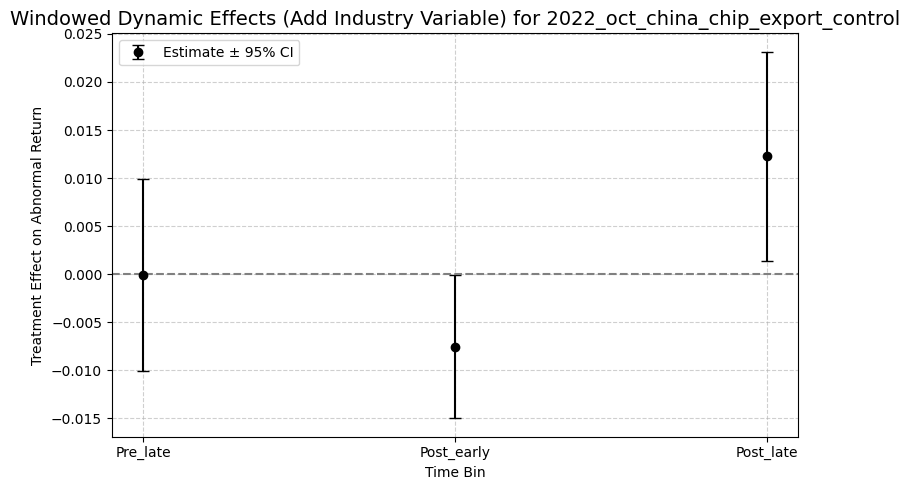

Processing event: 2023_chip_export_controls


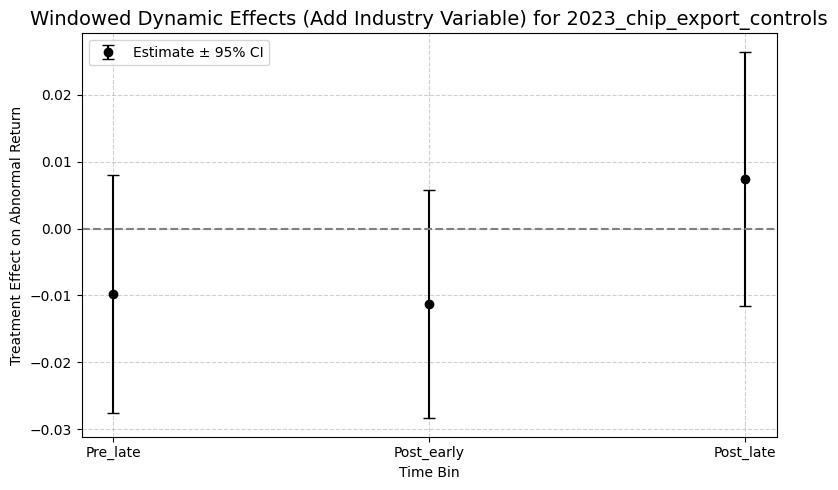

Processing event: 2023_mineral_export_restrictions


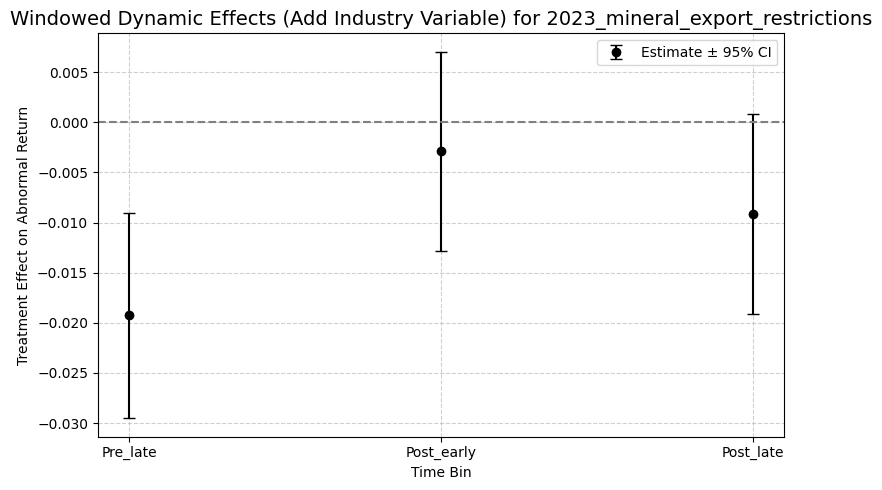

Processing event: 2023_aug_investment_ban


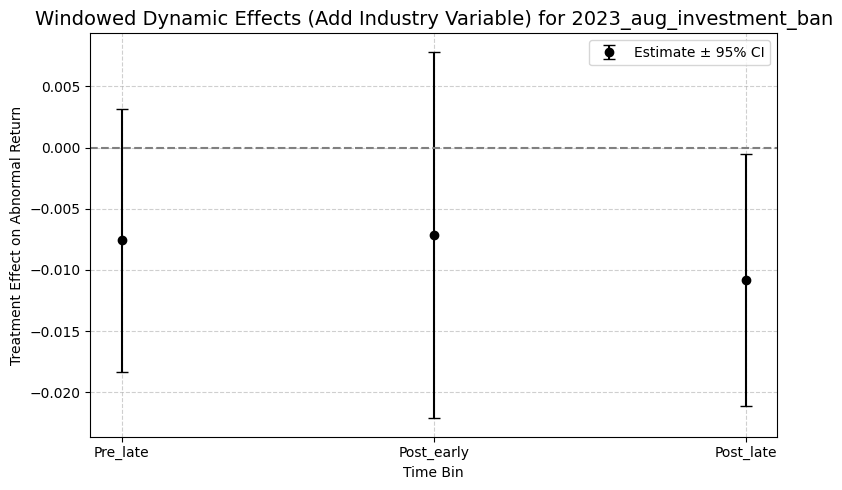

Processing event: 2023_export_expansion


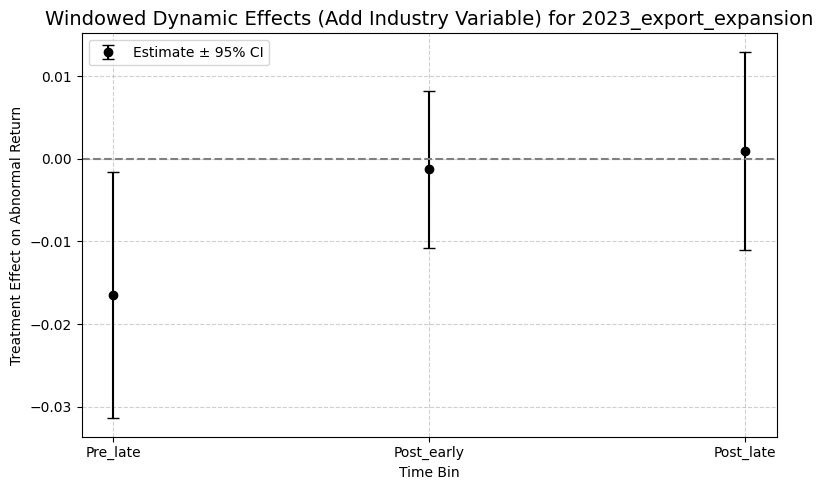

Processing event: 2024_march_export_tightening


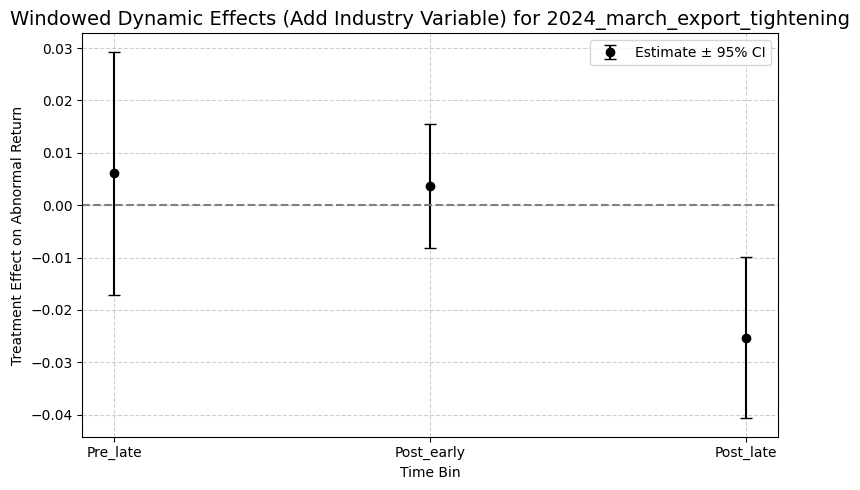

Processing event: 2024_tariff_increase_ev_battery


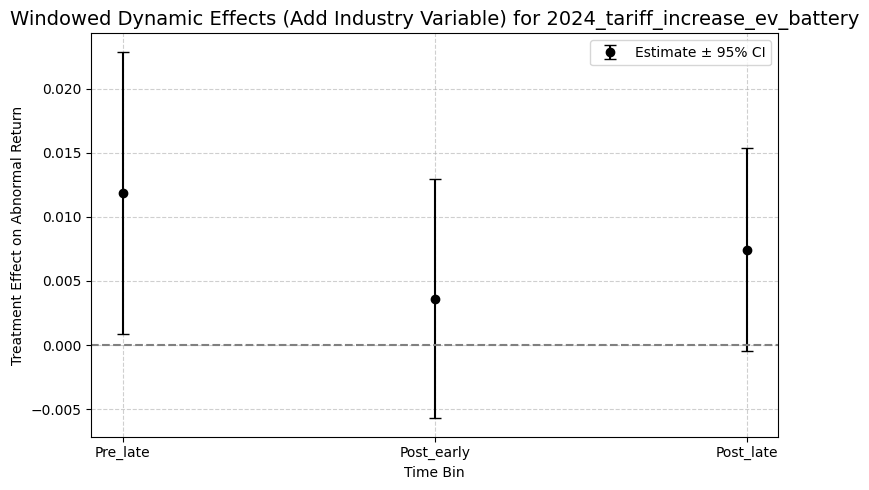

Processing event: 2024_tariff_finalization


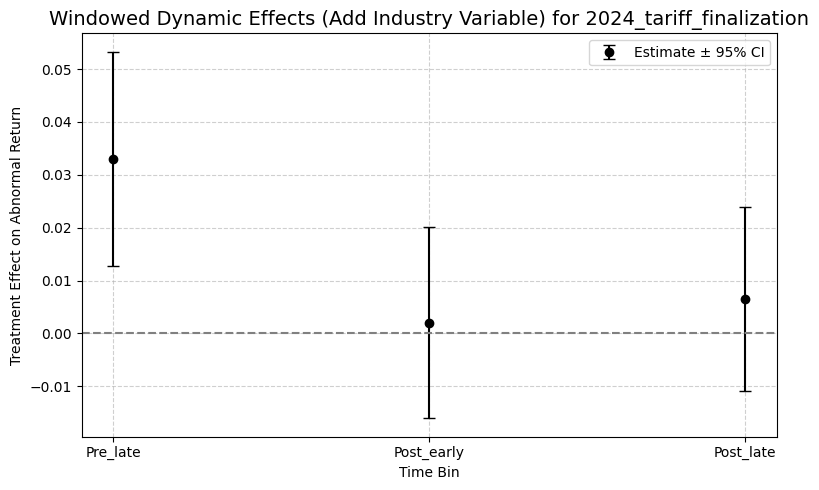

Processing event: 2024_nvidia_antitrust_probe


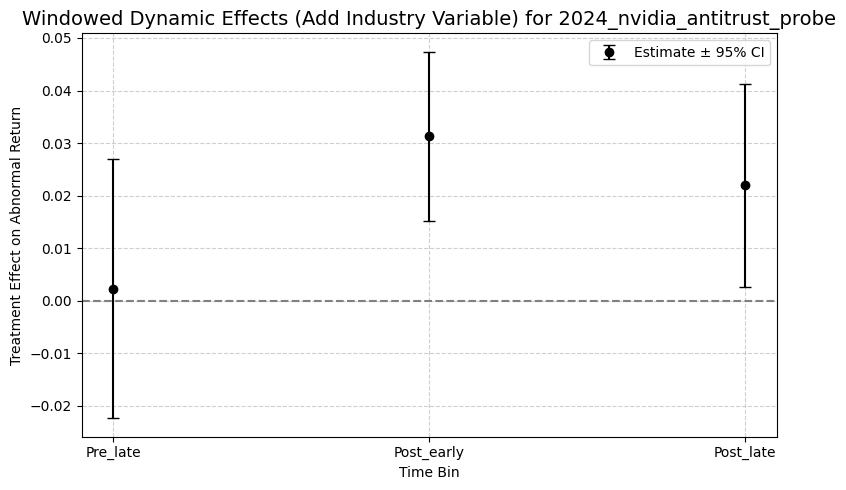

In [20]:
import statsmodels.api as sm

data["lagged_return"] = data.groupby("ticker")["Return"].shift(1)
data["absolute_return"] = data["Return"].abs()
data["abnormal_return"] = winsorize(data["abnormal_return"], limits=[0.01, 0.01])
data = data.dropna(subset=["lagged_return", "absolute_return", "CAR_pre"])

hardware = ["NVDA", "AMD", "INTC"]
software = ["CRM", "ORCL", "ADBE"]
etf = ["QQQ"]

def map_industry(ticker):
    if ticker in hardware:
        return "hardware"
    elif ticker in software:
        return "software"
    else:
        return "etf"

data["industry"] = data["ticker"].apply(map_industry)

bins = [-15, -3, 0, 5, 15]
labels = ["Pre_early", "Pre_late", "Post_early", "Post_late"]
data["time_bin"] = pd.cut(data["event_time"], bins=bins, labels=labels)

event_list = data["event_id"].unique()

for event in event_list:
    print(f"Processing event: {event}")
    
    df_event = data[data["event_id"] == event]
    
    if df_event["Treatment"].nunique() < 2:
        print(f"Skipping {event} due to lack of variation in Treatment")
        continue

    model = smf.ols(
        formula="abnormal_return ~ C(time_bin) * Treatment + C(ticker) + C(industry) + lagged_return + absolute_return + CAR_pre",
        data=df_event
    ).fit(cov_type='HAC', cov_kwds={'maxlags':1})
    
    coef = model.params
    conf = model.conf_int()

    treat_effect = coef[coef.index.str.contains(r'C\(time_bin\)\[T\..*\]:Treatment')].reset_index()
    treat_effect.columns = ['term', 'coef']

    conf_treat = conf.loc[treat_effect['term']]
    treat_effect['lower'] = conf_treat[0].values
    treat_effect['upper'] = conf_treat[1].values

    treat_effect['bin'] = treat_effect['term'].str.extract(r'\[T\.(.*)\]')[0]
    treat_effect['bin'] = pd.Categorical(treat_effect['bin'], categories=labels, ordered=True)
    treat_effect = treat_effect.sort_values('bin')

    plt.figure(figsize=(8, 5))
    plt.errorbar(
        treat_effect['bin'],
        treat_effect['coef'],
        yerr=[treat_effect['coef'] - treat_effect['lower'], treat_effect['upper'] - treat_effect['coef']],
        fmt='o', capsize=4, color='black', label='Estimate ± 95% CI'
    )
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f'Windowed Dynamic Effects (Add Industry Variable) for {event}', fontsize=14)
    plt.xlabel('Time Bin')
    plt.ylabel('Treatment Effect on Abnormal Return')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [21]:
# Regression Coefficients

model_dict = {}

for event in event_list:
    print(f"Processing event: {event}")
    
    df_event = data[data["event_id"] == event]
    
    if df_event["Treatment"].nunique() < 2:
        print(f"Skipping {event} due to lack of variation in Treatment")
        continue

    model = smf.ols(
        formula="abnormal_return ~ C(time_bin) * Treatment + C(ticker) + C(industry) + lagged_return + absolute_return + CAR_pre",
        data=df_event
    ).fit(cov_type='HAC', cov_kwds={'maxlags':1})

    model_dict[event] = model
    print(model.summary())
    print()
    print('-·'*60)
    print()

Processing event: 2022_oct_china_chip_export_control
                            OLS Regression Results                            
Dep. Variable:        abnormal_return   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     22.88
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           5.59e-26
Time:                        02:34:01   Log-Likelihood:                 257.06
No. Observations:                 102   AIC:                            -468.1
Df Residuals:                      79   BIC:                            -407.7
Df Model:                          22                                         
Covariance Type:                  HAC                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 28, but rank is 23
  warnings.warn('covariance of constraints does not have full '
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 28, but rank is 25
  warnings.warn('covariance of constraints does not have full '
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 28, but rank is 25
  warnings.warn('covariance of constraints does not have full '
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 28, but

---

- Extracts the treatment effect estimates at the Post_late stage for each event from the regression results.
- Collects the point estimates and their 95% confidence intervals into a DataFrame.
- Plots the Post_late treatment effects across different events with error bars representing confidence intervals.
- Helps to visually compare the strength and significance of the treatment effects at the Post_late period for all events.

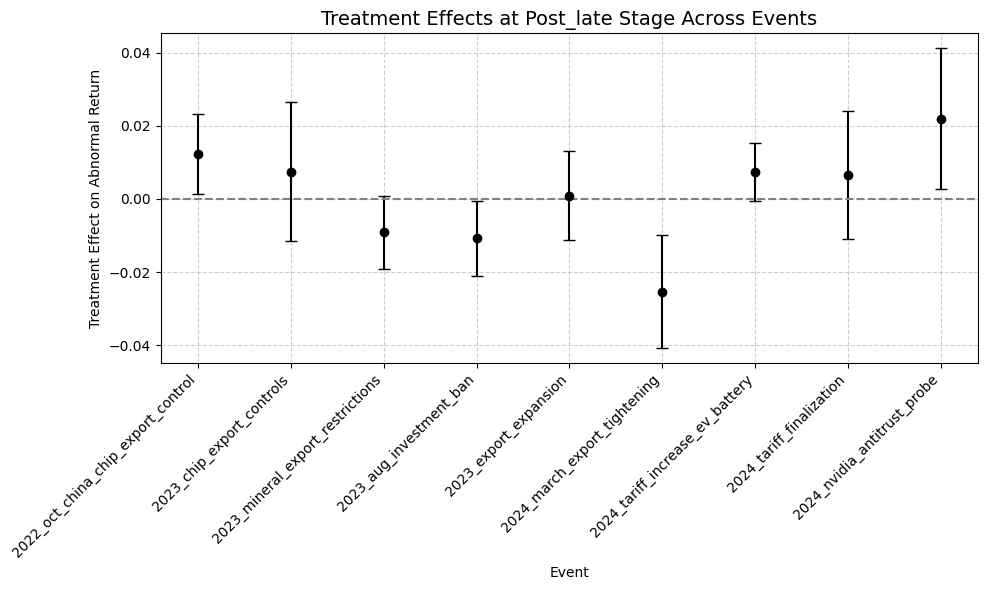

In [22]:
post_late_results = []

for event, model in model_dict.items():
    coef = model.params
    conf = model.conf_int()
    treat_terms = coef.index[coef.index.str.contains('C\\(time_bin\\)\\[T.Post_late\\]:Treatment')]
    term = treat_terms[0]
    post_late_results.append({
        "event": event,
        "coef": coef[term],
        "lower": conf.loc[term][0],
        "upper": conf.loc[term][1]
    })


post_late_df = pd.DataFrame(post_late_results)

plt.figure(figsize=(10, 6))
plt.errorbar(
    post_late_df["event"],
    post_late_df["coef"],
    yerr=[post_late_df["coef"] - post_late_df["lower"], post_late_df["upper"] - post_late_df["coef"]],
    fmt='o', capsize=4, color='black'
)
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.title("Treatment Effects at Post_late Stage Across Events", fontsize=14)
plt.xlabel("Event")
plt.ylabel("Treatment Effect on Abnormal Return")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

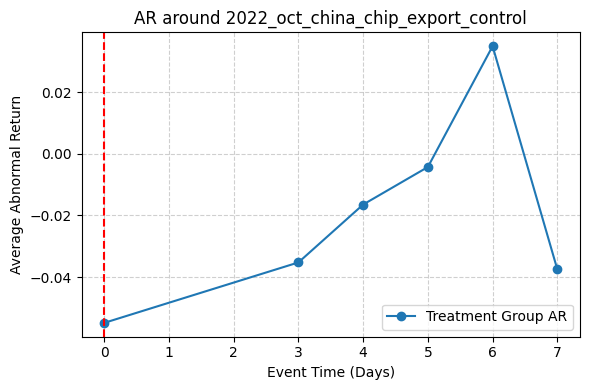

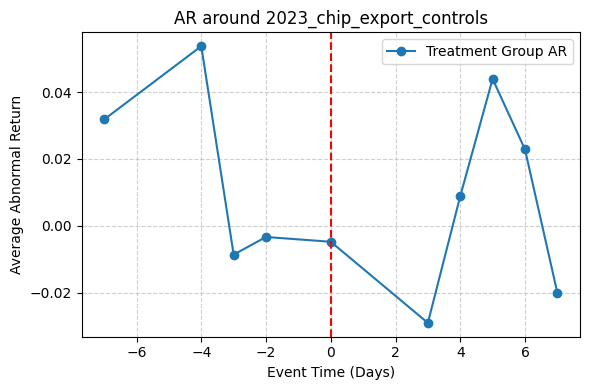

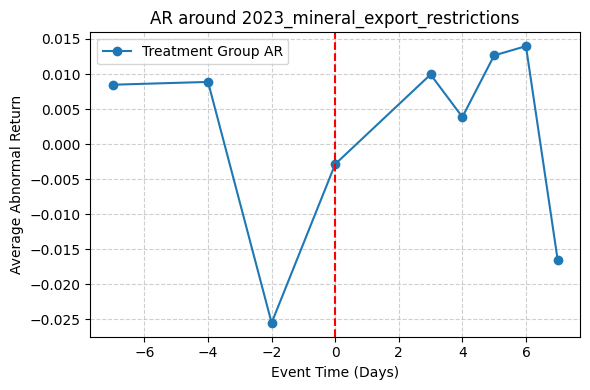

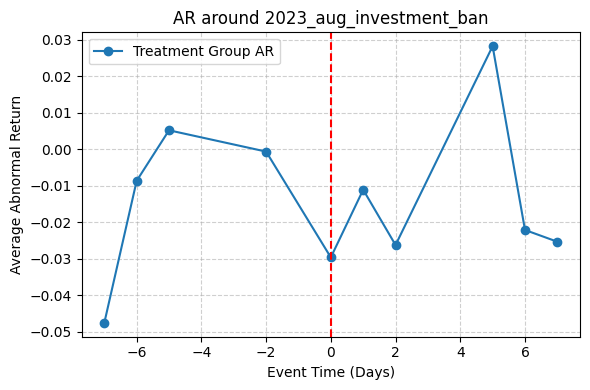

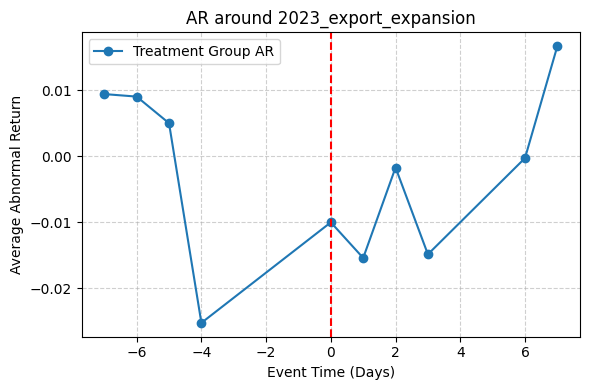

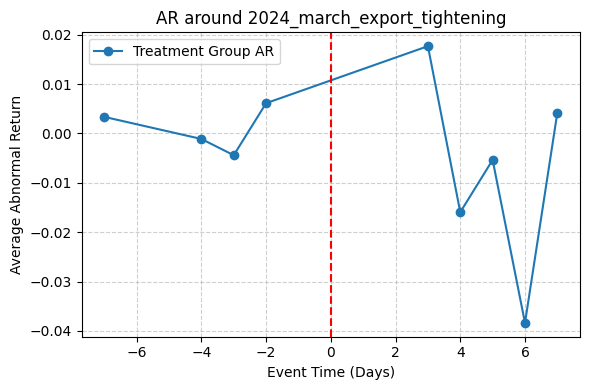

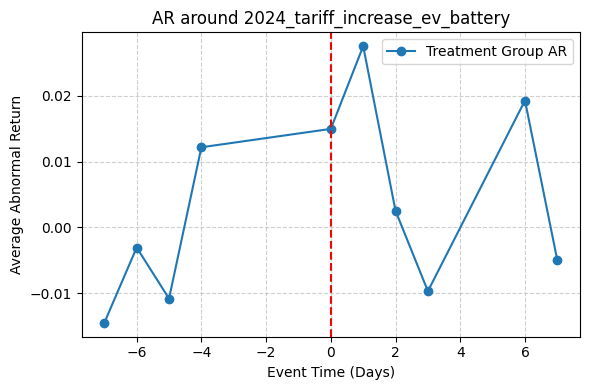

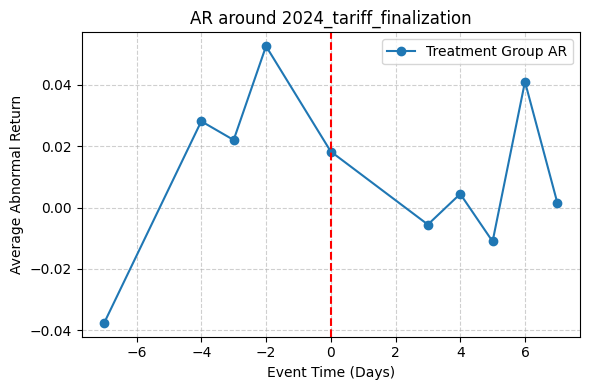

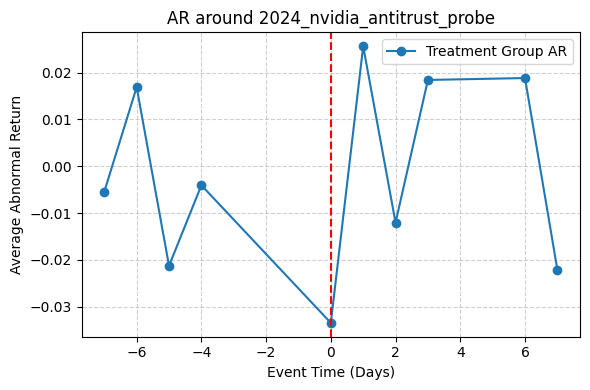

                             event_id  change_1day  change_5day
0  2022_oct_china_chip_export_control          NaN     0.050561
1           2023_chip_export_controls          NaN     0.048707
2    2023_mineral_export_restrictions          NaN     0.015520
3             2023_aug_investment_ban     0.018540     0.057864
4               2023_export_expansion    -0.005390          NaN
5        2024_march_export_tightening          NaN          NaN
6     2024_tariff_increase_ev_battery     0.012570          NaN
7            2024_tariff_finalization          NaN    -0.029281
8         2024_nvidia_antitrust_probe     0.059103          NaN


In [26]:
summary_results = []

for event in event_list:
    df_event = data[data['event_id'] == event]
    treat_group = df_event[df_event['Treatment'] == 1]
    treat_mean = treat_group.groupby('event_time')['abnormal_return'].mean()
    ar_day_0 = treat_mean.loc[0] if 0 in treat_mean.index else None
    ar_day_1 = treat_mean.loc[1] if 1 in treat_mean.index else None
    ar_day_5 = treat_mean.loc[5] if 5 in treat_mean.index else None

    if ar_day_0 is not None and ar_day_1 is not None:
        change_1day = ar_day_1 - ar_day_0
    else:
        change_1day = None

    if ar_day_0 is not None and ar_day_5 is not None:
        change_5day = ar_day_5 - ar_day_0
    else:
        change_5day = None

    summary_results.append({
        'event_id': event,
        'change_1day': change_1day,
        'change_5day': change_5day
    })

    plt.figure(figsize=(6,4))
    plt.plot(treat_mean.index, treat_mean.values, marker='o', label='Treatment Group AR')
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f'AR around {event}')
    plt.xlabel('Event Time (Days)')
    plt.ylabel('Average Abnormal Return')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

summary_df = pd.DataFrame(summary_results)
print(summary_df)